In [1]:
pwd

'/home/dcor/niskhizov'

In [2]:
cd Rar

/home/dcor/niskhizov/Rar


In [3]:
cd object-detection-nn

/home/dcor/niskhizov/Rar/object-detection-nn


In [4]:
# cd ../../..

In [5]:
remote_mode = True

import os
import numpy as np
from nn.YOLO_VGG16_OBB.utils.constants import ANCHORS
from nn.YOLO_VGG16_OBB.prepare_data.dota_dataset_memory import DotaDataset
from nn.YOLO_VGG16_OBB.prepare_data.transforms import train_transform, test_transform
from nn.YOLO_VGG16_OBB.utils.helpers import convert_cells_to_bboxes, load_checkpoint, nms, plot_image, save_checkpoint
from nn.YOLO_VGG16_OBB.utils.constants import device, s, leanring_rate, save_model, checkpoint_file
from nn.YOLO_VGG16_OBB.model.YOLO_VGG16_OBB import YOLO_VGG16_OBB
import torch
import torch.optim as optim
from nn.YOLO_VGG16_OBB.model.loss import YOLOLoss
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
import torchvision.transforms as T

if remote_mode:
    model_path_base = f"/home/dcor/niskhizov/Rar/object-detection-nn/nn/YOLO_VGG16_OBB/notebooks/vgg_f_obb_model"
else:
    model_path_base = f"nn/YOLO_VGG16_OBB/notebooks/"


/home/dcor/niskhizov/anaconda3/envs/obj_d/lib/python3.11/site-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.5' (you have '2.0.4'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [6]:
categories = ['plane','ship', 'storage-tank', 'baseball-diamond', 'tennis-court', 'basketball-court', 'ground-track-field', 'harbor', 'bridge', 'large-vehicle', 'small-vehicle', 'helicopter', 'roundabout', 'soccer-ball-field', 'swimming-pool']


In [7]:
# Creating the model from YOLOv3 class 
load_model = False
save_model = False
model = YOLO_VGG16_OBB(num_classes=len(categories)).to(device) 

# Defining the optimizer 
optimizer = optim.Adam(model.parameters(), lr = leanring_rate) 

# Defining the loss function 
loss_fn = YOLOLoss() 

# Defining the scaler for mixed precision training 
scaler = torch.amp.GradScaler(device=device) 
# Loading the checkpoint 
if load_model: 
    load_checkpoint(model_path_base + f"e108_b0_vgg16_{checkpoint_file}", model, optimizer, leanring_rate, device) 

# Initialize TensorBoard writer
writer = SummaryWriter(log_dir='runs/YOLO_VGG16_OBB_v2')



In [8]:
# import os
# import torch
# from torch.utils.data import Dataset
# from nn.YOLO_VGG16_OBB.utils.helpers import iou
# import cv2
# import numpy as np
# from PIL import Image
# # Create a dataset class to load the images and labels from the folder


# class DotaDataset(Dataset):
#     def __init__(
#             self, categories, anchors, transform=None, data_base_path=f"nn/dotadataset/train",
#             image_size=416, grid_sizes=[13, 26, 52]
#     ):
#         self.images_path = f"{data_base_path}/images"
#         self.labels_path = f"{data_base_path}/labelTxt-v1.0"
#         self.img_ids = [os.path.splitext(f)[0] for f in os.listdir(
#             self.images_path) if f.endswith('.png')]
#         self.cat_ids_map = {category: i for i,
#                             category in enumerate(categories)}
#         self.img_ids = self.img_ids[:10]
#         # Image size
#         self.image_size = image_size
#         # # Transformations
#         self.transform = transform(
#             image_size) if transform is not None else None
#         # self.transform = None
#         # Grid sizes for each scale
#         self.grid_sizes = grid_sizes
#         # Anchor boxes
#         self.anchors = torch.tensor(
#             anchors[0] + anchors[1] + anchors[2])
#         # Number of anchor boxes
#         self.num_anchors = self.anchors.shape[0]
#         # Number of anchor boxes per scale
#         self.num_anchors_per_scale = self.num_anchors // 3
#         # Number of classes
#         self.num_classes = len(categories)
#         # Ignore IoU threshold
#         self.ignore_iou_thresh = 0.5

#     def __len__(self):
#         return len(self.img_ids)

#     def __getitem__(self, idx):
#         error_counter = 0
#         while True:
#             try:
#                 return self.getitem_helper(idx)
#             except Exception as e:
#                 print(e)
#                 # choose random different idx
#                 idx = np.random.randint(0, len(self.img_ids))
#                 error_counter += 1
#                 if error_counter > 10:
#                     print("Too many errors")
#                     raise Exception("Too many errors")

#     def getitem_helper(self, idx):
#         img_id = self.img_ids[idx]
#         img_path = os.path.join(self.images_path, f"{img_id}.png")

#         # Load image from memory
#         img = cv2.imread(img_path)
#         if img is None:
#             raise Exception(f"Failed to load image from {img_path}")
#         img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
#         img = np.array(Image.fromarray(img), dtype=np.float32)
#         img_size_x = img.shape[1]
#         img_size_y = img.shape[0]
#         # Load labels
#         label_path = os.path.join(self.labels_path, f"{img_id}.txt")
#         if not os.path.exists(label_path):
#             raise Exception(f"Labels file not found: {label_path}")

#         bboxes = []
#         angles = []
#         with open(label_path, 'r') as f:
#             lines = f.readlines()
#             for line in lines:
#                 parts = line.strip().split()
#                 if len(parts) < 10:
#                     continue  # Skip invalid lines
#                 x1, y1, x2, y2, x3, y3, x4, y4 = map(float, parts[:8])
#                 category = parts[8]
#                 if category not in self.cat_ids_map:
#                     raise Exception(f"Unknown category: {category}")
#                 class_label = self.cat_ids_map[category]

#                 # Convert OBB to (cx, cy, w, h, angle)
#                 poly = np.array([[x1, y1], [x2, y2], [x3, y3], [
#                                 x4, y4]], dtype=np.float32).reshape((-1, 1, 2))
#                 rect = cv2.minAreaRect(poly)
#                 (cx, cy), (w, h), angle = rect
#                 n_cx, n_cy, n_w, n_h = cx / img_size_x, cy / img_size_y, w / img_size_x, h / img_size_y
#                 if (n_cx < 0 or n_cy < 0 or n_w < 0 or n_h < 0) or (n_cx > 1 or n_cy > 1 or n_w > 1 or n_h > 1):
#                     print('origin:', [x1, y1], [x2, y2], [x3, y3], [x4, y4])
#                     print('poly', poly)
#                     print('rect:', rect)
#                     print('cx:', cx, 'cy:', cy, 'w:',
#                           w, 'h:', h, 'angle:', angle)
#                 # else:
#                 #     print('No lower then 0:', n_cx, n_cy, n_w, n_h, angle)
#                 bboxes.append([n_cx, n_cy, n_w, n_h, class_label])
#                 angles.append(angle)
#         if self.transform is not None:
#             augs = self.transform(
#                 image=img, bboxes=bboxes)
#             img = augs["image"]
#             bboxes = [[cx, cy, w, h, angle, class_label] for (
#                 cx, cy, w, h, class_label), angle in zip(augs["bboxes"], angles)]
#         else:
#             bboxes = [[cx, cy, w, h, angle, class_label]
#                       for (cx, cy, w, h, class_label), angle in zip(bboxes, angles)]
#         # Below assumes 3 scale predictions (as paper) and same num of anchors per scale
#         # target : [probabilities, x, y, width, height, angle, class_label]
#         targets = [torch.zeros((self.num_anchors_per_scale, s, s, 7))
#                    for s in self.grid_sizes]

#         # Identify anchor box and cell for each bounding box
#         for box in bboxes:
#             # Calculate iou of bounding box with anchor boxes
#             iou_anchors = iou(torch.tensor(box[2:4]),
#                               self.anchors,
#                               is_pred=False)
#             # Selecting the best anchor box
#             anchor_indices = iou_anchors.argsort(descending=True, dim=0)
#             x, y, width, height, angle, class_label = box

#             if (x < 0 or y < 0 or width < 0 or height < 0) or (x > 1 or y > 1 or width > 1 or height > 1):
#                 print('x:', x, 'y:', y, 'w:',
#                         width, 'height:', height, 'angle:', angle)
              
#             if angle > 10 or angle < -10:
#                 print('angle:', angle)
#                 print('cordinates:', x, y, width, height)
#                 print('img_id:', img_id)      
#             # At each scale, assigning the bounding box to the
#             # best matching anchor box
#             has_anchor = [False] * 3

#             for anchor_idx in anchor_indices:
#                 scale_idx = anchor_idx // self.num_anchors_per_scale
#                 anchor_on_scale = anchor_idx % self.num_anchors_per_scale

#                 # Identifying the grid size for the scale
#                 s = self.grid_sizes[scale_idx]

#                 # Identifying the cell to which the bounding box belongs
#                 i, j = int(s * y), int(s * x)
#                 anchor_taken = targets[scale_idx][anchor_on_scale, i, j, 0]

#                 # Check if the anchor box is already assigned
#                 if not anchor_taken and not has_anchor[scale_idx]:

#                     # Set the probability to 1
#                     targets[scale_idx][anchor_on_scale, i, j, 0] = 1

#                     # Calculating the center of the bounding box relative
#                     # to the cell
#                     x_cell, y_cell = s * x - j, s * y - i

#                     # Calculating the width and height of the bounding box
#                     # relative to the cell
#                     width_cell, height_cell = (width * s, height * s)

#                     # Idnetify the box coordinates
#                     box_coordinates = torch.tensor(
#                         [x_cell, y_cell, width_cell,
#                          height_cell, angle]
#                     )

#                     # Assigning the box coordinates to the target
#                     targets[scale_idx][anchor_on_scale,
#                                        i, j, 1:6] = box_coordinates

#                     # Assigning the class label to the target
#                     targets[scale_idx][anchor_on_scale,
#                                        i, j, 6] = int(class_label)

#                     # Set the anchor box as assigned for the scale
#                     has_anchor[scale_idx] = True

#                     # If the anchor box is already assigned, check if the
#                     # IoU is greater than the threshold
#                 elif not anchor_taken and iou_anchors[anchor_idx] > self.ignore_iou_thresh:
#                     # Set the probability to -1 to ignore the anchor box
#                     targets[scale_idx][anchor_on_scale, i, j, 0] = -1

#                 # Return the image and the target
#         return img, tuple(targets)


In [9]:
dataset = DotaDataset( 
	categories=categories,
	grid_sizes=[13, 26, 52], 
	anchors=ANCHORS, 
	transform=train_transform 
) 

# Defining the train data loader 
train_loader = torch.utils.data.DataLoader( 
	dataset=dataset, 
	batch_size=8, 
	shuffle=True, 
	num_workers=2,
 	prefetch_factor=10,
) 


In [10]:
val_dataset = DotaDataset(
    categories=categories,
    grid_sizes=[13, 26, 52],
    anchors=ANCHORS,
    transform=test_transform,  # Use the same transform for validation
    data_base_path = f"nn/dotadataset/train"
)

# Create the validation data loader
val_loader = torch.utils.data.DataLoader(
    dataset=val_dataset,
    batch_size=8,
    shuffle=True,
)

val_loader_iter = iter(val_loader)

In [11]:
# Scaling the anchors 
scaled_anchors = ( 
	torch.tensor(ANCHORS) *
	torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
).to(device) 

In [12]:
# import cv2
# import matplotlib.pyplot as plt
# import numpy as np
# from nn.YOLO_VGG16_OBB.utils.helpers import iou

# def plot_image(image, boxes, labels, display=True):
#     # Getting the color map from matplotlib
#     colour_map = plt.get_cmap("tab20b")

#     # Convert image to NumPy array (if not already)
#     img = np.array(image)
#     h, w, _ = img.shape

#     # Copy the image to avoid modifying the original
#     img_drawn = img.copy()

#     # Plot bounding boxes and labels
#     for box in boxes:
#         class_pred = int(box[0])
#         cx, cy, bw, bh, angle = box[2:]

#         # Convert to absolute coordinates
#         cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h

#         # Get color
#         color = colour_map(class_pred)
#         # Get rotated rectangle
#         rect = ((cx, cy), (bw, bh), angle)  # OpenCV expects angle in degrees
#         box_points = cv2.boxPoints(rect)  # Get corner points
#         box_points = np.int32(box_points)  # Convert to integer

#         # Draw the rotated rectangle
#         cv2.polylines(img_drawn, [box_points], isClosed=True, color=color, thickness=2)

#         # Put label text near the rectangle
#         # label = labels[class_pred]
#         # (text_width, text_height), baseline = cv2.getTextSize(
#         #     label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
#         # text_x, text_y = int(cx - text_width / 2), int(cy - bh / 2 - 10)
#         # cv2.rectangle(img_drawn, (text_x, text_y - text_height - 4),
#         #               (text_x + text_width, text_y), color, -1)
#         # cv2.putText(img_drawn, label, (text_x, text_y),
#         #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

#     if display:
#         # Display the image
#         plt.figure(figsize=(8, 6))
#         plt.imshow(cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
#         plt.axis("off")
#         plt.show()

#     return img_drawn  # Return the modified image with drawn bounding boxes


In [13]:
# def convert_cells_to_bboxes(predictions, anchors, s, is_predictions=True):
#     # Batch size used on predictions
#     batch_size = predictions.shape[0]
#     # Number of anchors
#     num_anchors = len(anchors)
#     # List of all the predictions
#     box_predictions = predictions[..., 1:5]

#     # If the input is predictions then we will pass the x and y coordinate
#     # through sigmoid function and width and height to exponent function and
#     # calculate the score and best class.
#     if is_predictions:
#         anchors = anchors.reshape(1, len(anchors), 1, 1, 2)
#         box_predictions[..., 0:2] = torch.sigmoid(box_predictions[..., 0:2])
#         box_predictions[..., 2:] = torch.exp(
#             box_predictions[..., 2:]) * anchors
#         scores = torch.sigmoid(predictions[..., 0:1])
#         best_class = torch.argmax(predictions[..., 6:], dim=-1).unsqueeze(-1)

#     # Else we will just calculate scores and best class.
#     else:
#         scores = predictions[..., 0:1]
#         best_class = predictions[..., 6:7]

#     # Calculate cell indices
#     cell_indices = (
#         torch.arange(s)
#         .repeat(predictions.shape[0], 3, s, 1)
#         .unsqueeze(-1)
#         .to(predictions.device)
#     )

#     # Calculate x, y, width and height with proper scaling
#     x = 1 / s * (box_predictions[..., 0:1] + cell_indices)
#     y = 1 / s * (box_predictions[..., 1:2] +
#                  cell_indices.permute(0, 1, 3, 2, 4))
#     width_height = 1 / s * box_predictions[..., 2:4]
#     angle = predictions[..., 5:6]
#     # Concatinating the values and reshaping them in
#     # (BATCH_SIZE, num_anchors * S * S, 7) shape
#     converted_bboxes = torch.cat(
#         (best_class, scores, x, y, width_height, angle), dim=-1
#     ).reshape(batch_size, num_anchors * s * s, 7)

#     # Returning the reshaped and converted bounding box list
#     return converted_bboxes.tolist()


Expected y_min for bbox [ 0.7416651  -0.01117727  0.80520296  0.10158312  7.        ] to be in the range [0.0, 1.0], got -0.011177271604537964.
###################################### display and report image ######################################
bboxes[i] shape: (10647, 7)


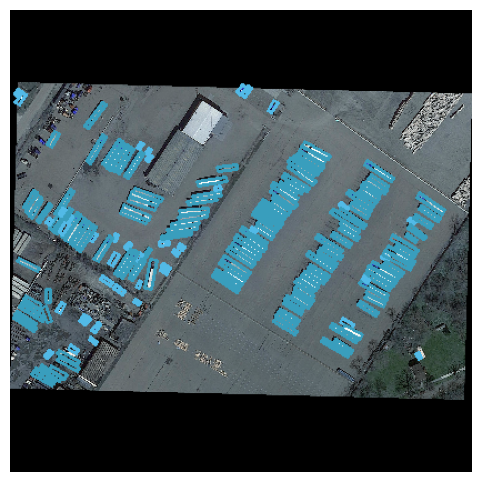

In [16]:
model.eval()

# Getting a sample image from the test data loader 
try:
	x, y = next(val_loader_iter)
except StopIteration:
	val_loader_iter = iter(val_loader)
	x, y = next(val_loader_iter)
x = x.to(device) 

print("###################################### display and report image ######################################")
with torch.no_grad():
	scaled_anchors = ( 
	torch.tensor(ANCHORS) *
	torch.tensor(s).unsqueeze(1).unsqueeze(1).repeat(1,3,2) 
	).to(device) 
	output = model(x)
	y0, y1, y2 = ( 
		y[0].to(device), 
		y[1].to(device), 
		y[2].to(device), 
	) 

	with torch.amp.autocast(device_type=device): 
		# Getting the model predictions 
		outputs = model(x) 
		# Calculating the loss at each scale 
		loss = ( 
			loss_fn(outputs[0], y0, scaled_anchors[0]) 
			+ loss_fn(outputs[1], y1, scaled_anchors[1]) 
			+ loss_fn(outputs[2], y2, scaled_anchors[2]) 
		) 

	# TEMP- print target boxes
	bboxes = [[] for _ in range(x.shape[0])]
	for i in range(3):
		batch_size, A, S, _, _ = y[i].shape
		anchor = scaled_anchors[i]
		boxes_scale_i = convert_cells_to_bboxes(y[i], anchor, s=S, is_predictions=False)
		for idx, box in enumerate(boxes_scale_i):
			bboxes[idx] += box

	i = 0
	print('bboxes[i] shape:', np.array(bboxes[i]).shape)
	nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6)
	img_with_boxes = plot_image(x[i].permute(1, 2, 0).detach().cpu(), nms_boxes, categories)
	img_with_boxes = T.ToTensor()(img_with_boxes)

	# # Print predictions
	# writer.add_scalar('Loss/val', loss.item(), e * len(train_loader) + batch_idx)

	# bboxes = [[] for _ in range(x.shape[0])]
	# for i in range(3):
	# 	batch_size, A, S, _, _ = output[i].shape
	# 	anchor = scaled_anchors[i]
	# 	boxes_scale_i = convert_cells_to_bboxes(output[i], anchor, s=S, is_predictions=True)
	# 	for idx, box in enumerate(boxes_scale_i):
	# 		bboxes[idx] += box

	# i = 0
	# print('bboxes[i] shape:', np.array(bboxes[i]).shape)
	# nms_boxes = nms(bboxes[i], iou_threshold=0.5, threshold=0.6)
	# img_with_boxes = plot_image(x[i].permute(1, 2, 0).detach().cpu(), nms_boxes, categories)
	# img_with_boxes = T.ToTensor()(img_with_boxes)
	# writer.add_image(f'Val/Image_{e}_{i}_{batch_idx}_before', img_with_boxes, e * len(train_loader) + batch_idx)

# model.train()
# except Exception as error:
# 	print(error)
# 	error_counter += 1
# 	if error_counter > 10:
# 		raise error


#################
# training_loop(train_loader, model, optimizer, loss_fn, scaler, scaled_anchors) 


In [68]:
nms_boxes[0]

[10.0,
 1.0,
 0.1392921358346939,
 0.13048575818538666,
 0.0064709787257015705,
 0.016574036329984665,
 0.21546246111392975]

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
from nn.YOLO_VGG16_OBB.utils.helpers import iou

def plot_image(image, boxes, labels, display=True):
    # Getting the color map from matplotlib
    colour_map = plt.get_cmap("tab20b")

    # Convert image to NumPy array (if not already)
    img = np.array(image)
    h, w, _ = img.shape

    # Copy the image to avoid modifying the original
    img_drawn = img.copy()

    # Plot bounding boxes and labels
    for box in boxes:
        class_pred = int(box[0])
        cx, cy, bw, bh, angle = box[2:]

        # Convert to absolute coordinates
        cx, cy, bw, bh = cx * w, cy * h, bw * w, bh * h

        # Get color
        color = tuple(int(c * 255) for c in colour_map(class_pred + 100)[:3])
        if angle > 10:
            print(angle)
        # Get rotated rectangle
        rect = ((cx, cy), (bw, bh), angle)  # OpenCV expects angle in degrees
        box_points = cv2.boxPoints(rect)  # Get corner points
        box_points = np.int32(box_points)  # Convert to integer

        # Draw the rotated rectangle
        cv2.polylines(img_drawn, [box_points], isClosed=True, color=color, thickness=1)

        # Put label text near the rectangle
        # label = labels[class_pred]
        # (text_width, text_height), baseline = cv2.getTextSize(
        #     label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 2)
        # text_x, text_y = int(cx - text_width / 2), int(cy - bh / 2 - 10)
        # cv2.rectangle(img_drawn, (text_x, text_y - text_height - 4),
        #               (text_x + text_width, text_y), color, -1)
        # cv2.putText(img_drawn, label, (text_x, text_y),
        #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 255, 255), 1)

    if display:
        # Display the image
        plt.figure(figsize=(8, 6))
        plt.imshow(cv2.cvtColor(img_drawn, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB
        plt.axis("off")
        plt.show()

    return img_drawn  # Return the modified image with drawn bounding boxes


In [13]:
def nms(bboxes_orig, iou_threshold, threshold):
    # Filter out bounding boxes with confidence below the threshold.
    bboxes = [box for box in bboxes_orig if box[1] > threshold]

    # Sort the bounding boxes by confidence in descending order.
    bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

    # Initialize the list of bounding boxes after non-maximum suppression.
    if (len(bboxes) > 0):
        first_box = bboxes.pop(0)
        bboxes_nms = [first_box]
    else:
        bboxes_nms = [max(bboxes_orig, key=lambda x: x[1])]

    while len(bboxes) >= 0:
        # Iterate over the remaining bounding boxes.
        for box in bboxes:
            # If the bounding boxes do not overlap or if the first bounding box has
            # a higher confidence, then add the second bounding box to the list of
            # bounding boxes after non-maximum suppression.
            if box[0] != first_box[0] or iou(
                    torch.tensor([first_box[2:]]),
                    torch.tensor([box[2:]]),
            ) < iou_threshold:
                # Check if box is not in bboxes_nms
                if box not in bboxes_nms:
                    # Add box to bboxes_nms
                    bboxes_nms.append(box)

        # Get the first bounding box.
        if len(bboxes) > 0:
            first_box = bboxes.pop(0)
        else:
            break

    # Return bounding boxes after non-maximum suppression.
    return bboxes_nms

In [ ]:
obj = target[..., 0] == 1
no_obj = target[..., 0] == 0

# Calculating No object loss 
no_object_loss = 4 * bce( 
    (pred[..., 0:1][no_obj]), (target[..., 0:1][no_obj]), 
) 


# Reshaping anchors to match predictions 
anchors = anchors.reshape(1, 3, 1, 1, 2) 
# Box prediction confidence 
box_preds = torch.cat([sigmoid(pred[..., 1:3]), 
                    torch.exp(pred[..., 3:5]) * anchors, pred[..., 5].unsqueeze(-1)
                    ],dim=-1) 
# Calculating intersection over union for prediction and target 
ious = iou(box_preds[obj], target[..., 1:6][obj]).detach() 
ious = ious.unsqueeze(1)
object_loss = mse(sigmoid(pred[..., 0:1][obj]), 
                    ious * target[..., 0:1][obj]) 



In [ ]:
ious.unsqueeze(1).shape

torch.Size([202, 1])

In [ ]:
box_preds[obj].shape

NameError: name 'box_preds' is not defined

In [ ]:
converted_bboxes = torch.cat(
    (best_class, scores, x, y, width_height, angle.unsqueeze(0)), dim=-1
).reshape(batch_size, num_anchors * s * s, 7)

RuntimeError: Tensors must have same number of dimensions: got 5 and 6

In [ ]:
angle.shape

torch.Size([1, 3, 13, 13, 0])

In [ ]:
scaled_anchors.shape

torch.Size([3, 3, 2])

In [ ]:
anchor.shape
anchors = anchor.reshape(1, len(anchor), 1, 1, 2)


In [ ]:
anchors.shape

torch.Size([1, 3, 1, 1, 2])

In [ ]:
box_predictions.shape

torch.Size([1, 3, 13, 13, 4])

In [ ]:
box_predictions[..., 2:5].shape

torch.Size([1, 3, 13, 13, 3])

In [ ]:
box_predictions = output[i][..., 1:6]


In [ ]:
torch.exp(box_predictions[..., 2:]) * anchors

tensor([[[[[ 3.4525,  3.0396],
           [ 3.4055,  2.9636],
           [ 3.3956,  2.9771],
           ...,
           [ 3.3992,  2.9820],
           [ 3.3985,  2.9832],
           [ 3.3449,  2.9895]],

          [[ 3.4627,  3.0176],
           [ 3.4604,  2.9411],
           [ 3.4555,  2.9476],
           ...,
           [ 3.4551,  2.9515],
           [ 3.4574,  2.9576],
           [ 3.4547,  2.9203]],

          [[ 3.4585,  3.0207],
           [ 3.4460,  2.9506],
           [ 3.4472,  2.9532],
           ...,
           [ 3.4449,  2.9541],
           [ 3.4508,  2.9598],
           [ 3.4502,  2.9210]],

          ...,

          [[ 3.4596,  3.0190],
           [ 3.4384,  2.9427],
           [ 3.4408,  2.9580],
           ...,
           [ 3.4405,  2.9566],
           [ 3.4365,  2.9704],
           [ 3.4443,  2.9293]],

          [[ 3.4514,  2.9987],
           [ 3.4252,  2.9310],
           [ 3.4301,  2.9355],
           ...,
           [ 3.4237,  2.9288],
           [ 3.4292,  2.9430

In [ ]:
torch.exp(output[i][..., 2:]).shape

torch.Size([1, 3, 13, 13, 19])

In [ ]:
import cv2

In [ ]:
pwd

In [ ]:
cd nn/YOLO_VGG16/prepare_data/

In [ ]:
img_path = f'../../cocodataset/images/train2017/000000111341.jpg'
img = cv2.imread(img_path)


In [ ]:
# iterator = next(iter(train_loader))

In [ ]:
import numpy as np
from nn.YOLO_VGG16_OBB.utils.helpers import iou

In [ ]:
np.array(bboxes[i]).shape

(10647, 6)

In [ ]:
bboxes_orig, iou_threshold, threshold = bboxes[i], 0.5, 0.6
# Filter out bounding boxes with confidence below the threshold.
bboxes = [box for box in bboxes_orig if box[1] > threshold]

# Sort the bounding boxes by confidence in descending order.
bboxes = sorted(bboxes, key=lambda x: x[1], reverse=True)

# Initialize the list of bounding boxes after non-maximum suppression.
if (len(bboxes) > 0):
    first_box = bboxes.pop(0)
    bboxes_nms = [first_box]
else:
    bboxes_nms = [max(bboxes_orig, key=lambda x: x[1])]

while len(bboxes) >= 0:
    # Iterate over the remaining bounding boxes.
    for box in bboxes:
        # If the bounding boxes do not overlap or if the first bounding box has
        # a higher confidence, then add the second bounding box to the list of
        # bounding boxes after non-maximum suppression.
        if box[0] != first_box[0] or iou(
                torch.tensor(first_box[1:]),
                torch.tensor(box[1:]),
        ) < iou_threshold:
            print('**************************')


TypeError: 'float' object is not subscriptable

In [ ]:
i

0

In [ ]:
bboxes[5]

[5.0,
 0.6013601422309875,
 0.5170402526855469,
 0.6361819505691528,
 0.11489986628293991,
 0.26433518528938293]

In [ ]:
first_box

[5.0,
 0.6182487607002258,
 0.4791613221168518,
 0.4037945866584778,
 0.11246916651725769,
 0.25277405977249146]